In [38]:
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [39]:
num_particles = 30
max_iterations = 50
w = 0.8  
c1 = 1.5  
c2 = 1.5  

# Format: ID, Tonase, Jenis (0=biasa, 1=khusus), Jarak Tujuan
containers = [
    (1, 5, 0, 300),  
    (2, 8, 0, 500),  
    (3, 6, 1, 200),   
    (4, 10, 0, 800),  
    (5, 7, 0, 400),  
    (6, 9, 1, 600),   
    (7, 4, 0, 700),  
    (8, 12, 0, 100),  
    (9, 5, 0, 900),   
    (10, 8, 1, 250)   
]

ship_max_tonnage = 60
special_container_locations = [0, 1, 2] 
regular_fee_per_ton = 100
special_fee_per_ton = 300  

In [40]:
class Particle:
    def __init__(self, num_containers):
        self.position = list(range(1, num_containers + 1))
        random.shuffle(self.position)
        
        self.velocity = []
        
        self.pbest_position = self.position.copy()
        self.pbest_fitness = self.calculate_fitness(self.position)
    
    def calculate_fitness(self, position):
        total_revenue = 0
        penalties = 0
        total_tonnage = 0
        
        container_map = {c[0]: c for c in containers}
        
        for i, container_id in enumerate(position):
            container = container_map[container_id]
            tonnage = container[1]
            is_special = container[2]
            distance = container[3]
         
            total_tonnage += tonnage
            
            if is_special:
                total_revenue += tonnage * special_fee_per_ton
                if i not in special_container_locations:
                    penalties += 5000
            else:
                total_revenue += tonnage * regular_fee_per_ton
            
            for j in range(i+1, len(position)):
                other_id = position[j]
                other_container = container_map[other_id]
                other_distance = other_container[3]
                
                if distance < other_distance:
                    penalties += 500
        
        if total_tonnage > ship_max_tonnage:
            penalties += 10000
        
        return total_revenue - penalties
    
    def update_velocity(self, gbest_position):
        new_velocity = []
     
        if random.random() < w and self.velocity:
            num_ops = max(1, int(w * len(self.velocity)))
            new_velocity.extend(random.sample(self.velocity, num_ops))
        
        if random.random() < c1:
            diff_pbest = self.get_swaps(self.position, self.pbest_position)
            num_swaps = int(c1 * random.random() * len(diff_pbest))
            if diff_pbest and num_swaps > 0:
                new_velocity.extend(random.sample(diff_pbest, min(num_swaps, len(diff_pbest))))
        
        if random.random() < c2:
            diff_gbest = self.get_swaps(self.position, gbest_position)
            num_swaps = int(c2 * random.random() * len(diff_gbest))
            if diff_gbest and num_swaps > 0:
                new_velocity.extend(random.sample(diff_gbest, min(num_swaps, len(diff_gbest))))
        
        self.velocity = new_velocity
    
    def get_swaps(self, arr1, arr2):
        swaps = []
        temp = arr1.copy()
        
        for i in range(len(arr1)):
            if temp[i] != arr2[i]:
                j = temp.index(arr2[i])
                swaps.append((i, j))
                temp[i], temp[j] = temp[j], temp[i]
        
        return swaps
    
    def update_position(self):
        new_position = self.position.copy()
        
        for swap in self.velocity:
            i, j = swap
            if 0 <= i < len(new_position) and 0 <= j < len(new_position):
                new_position[i], new_position[j] = new_position[j], new_position[i]
        
        new_fitness = self.calculate_fitness(new_position)
        current_fitness = self.calculate_fitness(self.position)
        
        if new_fitness > current_fitness or random.random() < 0.1:
            self.position = new_position
        
        if new_fitness > self.pbest_fitness:
            self.pbest_position = new_position.copy()
            self.pbest_fitness = new_fitness

In [41]:
particles = [Particle(len(containers)) for _ in range(num_particles)]

gbest_position = particles[0].position.copy()
gbest_fitness = particles[0].pbest_fitness

for p in particles:
    if p.pbest_fitness > gbest_fitness:
        gbest_fitness = p.pbest_fitness
        gbest_position = p.pbest_position.copy()

iteration_data = []
best_fitness_history = []
avg_fitness_history = []
particle_positions = defaultdict(list)


In [42]:
def get_container_info(container_id):
    for c in containers:
        if c[0] == container_id:
            return c
    return None

def visualize_container_placement(position, iteration):
    container_map = {c[0]: c for c in containers}
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, container_id in enumerate(position):
        container = container_map[container_id]
        tonnage = container[1]
        is_special = container[2]
        distance = container[3]
        
        color = 'gold' if is_special else 'skyblue'
        ax.bar(0, tonnage, bottom=sum(container_map[position[j]][1] for j in range(i)), 
               width=0.5, color=color, edgecolor='black')
        
        y_pos = sum(container_map[position[j]][1] for j in range(i)) + tonnage/2
        ax.text(0, y_pos, f"ID: {container_id}\n{tonnage}ton\nDist: {distance}",
                ha='center', va='center')
    
    ax.set_title(f'Peletakan Peti Kemas (Iterasi {iteration})')
    ax.set_ylim(0, ship_max_tonnage * 1.1)
    ax.set_xticks([])
    ax.axhline(y=ship_max_tonnage, color='r', linestyle='--', label=f'Max Tonnage: {ship_max_tonnage}')
    
    for loc in special_container_locations:
        if loc < len(position):
            height = sum(container_map[position[j]][1] for j in range(loc+1))
            ax.axhline(y=height, color='green', linestyle=':', alpha=0.5)
    
    ax.legend()
    return fig

In [47]:
for iteration in range(max_iterations):
    
    current_data = {
        'iteration': iteration+1,
        'gbest_position': gbest_position.copy(),
        'gbest_fitness': gbest_fitness,
        'particles': []
    }
    
    for i, p in enumerate(particles):
        current_data['particles'].append({
            'id': i,
            'position': p.position.copy(),
            'fitness': p.calculate_fitness(p.position)
        })
        particle_positions[i].append(p.position.copy())
    
    iteration_data.append(current_data)
    
    avg_fitness = sum(p.calculate_fitness(p.position) for p in particles) / len(particles)
    best_fitness_history.append(gbest_fitness)
    avg_fitness_history.append(avg_fitness)
    
    for p in particles:
        p.update_velocity(gbest_position)
        p.update_position()
        
        if p.pbest_fitness > gbest_fitness:
            gbest_fitness = p.pbest_fitness
            gbest_position = p.pbest_position.copy()

In [44]:
current_data = {
    'iteration': max_iterations,
    'gbest_position': gbest_position.copy(),
    'gbest_fitness': gbest_fitness,
    'particles': []
}

for i, p in enumerate(particles):
    current_data['particles'].append({
        'id': i,
        'position': p.position.copy(),
        'fitness': p.calculate_fitness(p.position)
    })
    particle_positions[i].append(p.position.copy())

iteration_data.append(current_data)

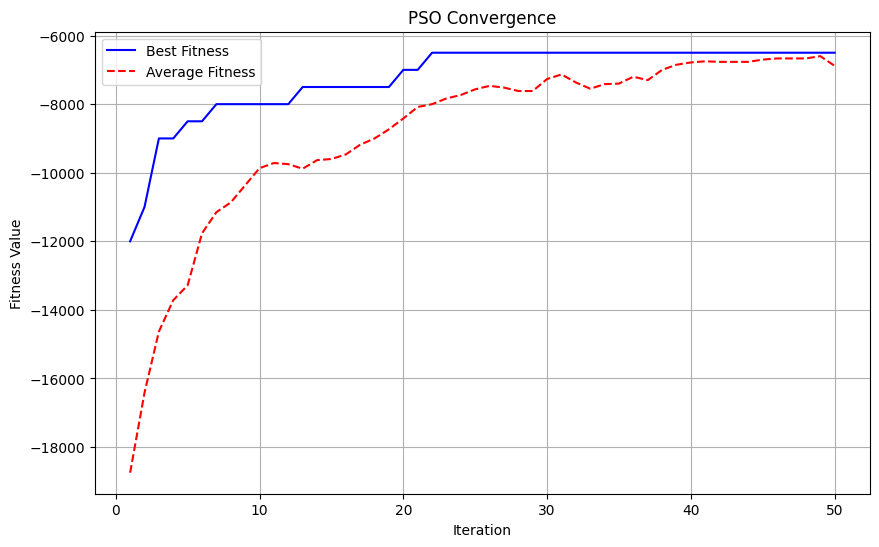


Hasil Optimasi PSO setelah 50 iterasi:
Best Position: [9, 6, 10, 4, 7, 2, 5, 1, 3, 8]
Best Fitness: -6500


In [45]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations+1), best_fitness_history, 'b-', label='Best Fitness')
plt.plot(range(1, max_iterations+1), avg_fitness_history, 'r--', label='Average Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness Value')
plt.title('PSO Convergence')
plt.legend()
plt.grid(True)
plt.show()

print("\nHasil Optimasi PSO setelah", max_iterations, "iterasi:")
print("Best Position:", gbest_position)
print("Best Fitness:", gbest_fitness)


Total Tonase: 74 ton dari maksimum 60 ton
Jumlah peti kemas khusus: 3

Peletakan Peti Kemas (dari bawah ke atas):
Position | ID | Tonase | Jenis | Tujuan (km) | Keterangan
----------------------------------------------------------------------
       0 |  9 |      5 | Biasa  |         900 | Lokasi Khusus
       1 |  6 |      9 | Khusus |         600 | Lokasi Khusus
       2 | 10 |      8 | Khusus |         250 | Lokasi Khusus
       3 |  4 |     10 | Biasa  |         800 | 
       4 |  7 |      4 | Biasa  |         700 | 
       5 |  2 |      8 | Biasa  |         500 | 
       6 |  5 |      7 | Biasa  |         400 | 
       7 |  1 |      5 | Biasa  |         300 | 
       8 |  3 |      6 | Khusus |         200 | 
       9 |  8 |     12 | Biasa  |         100 | 


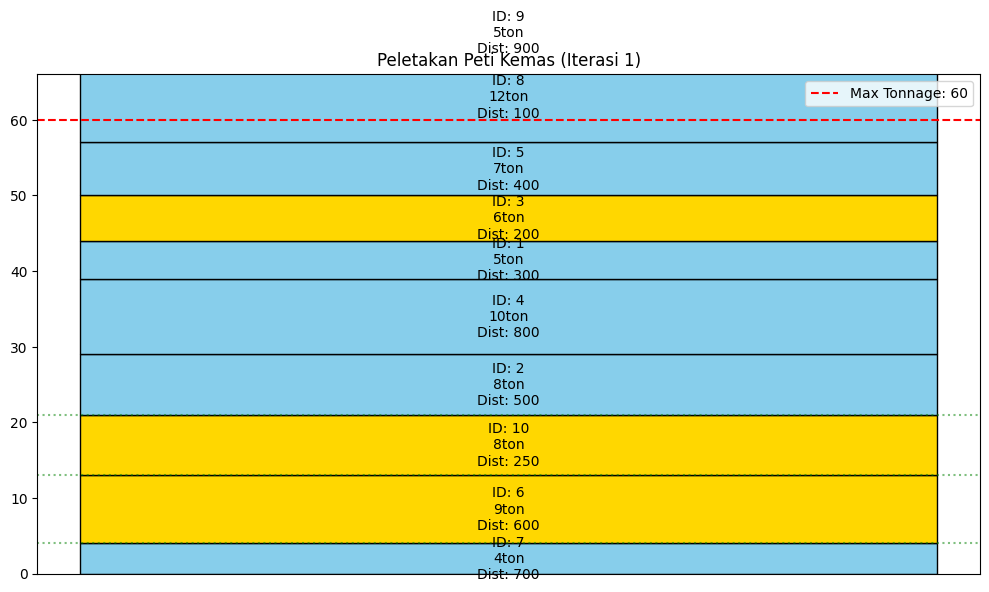

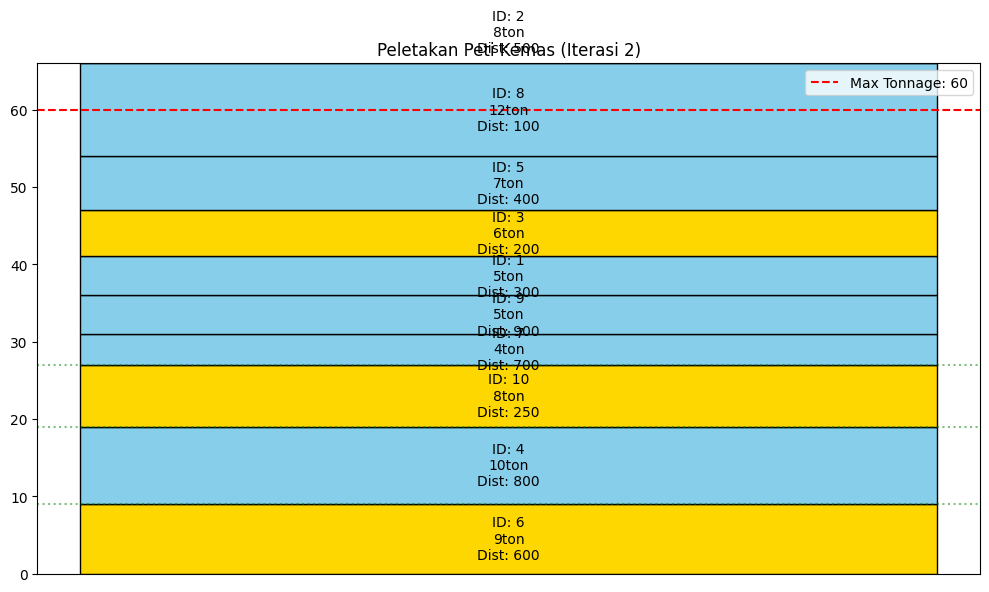

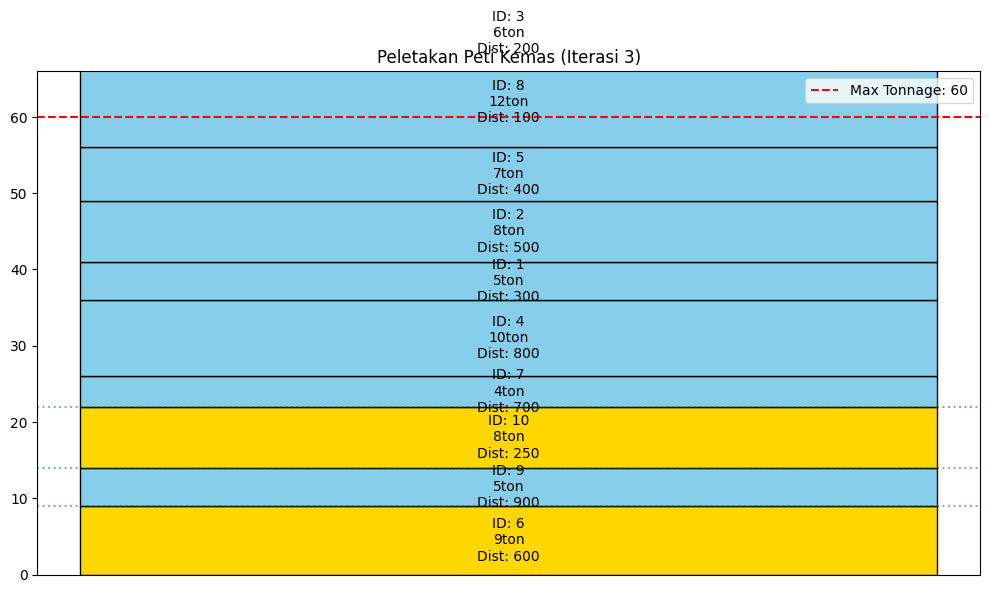

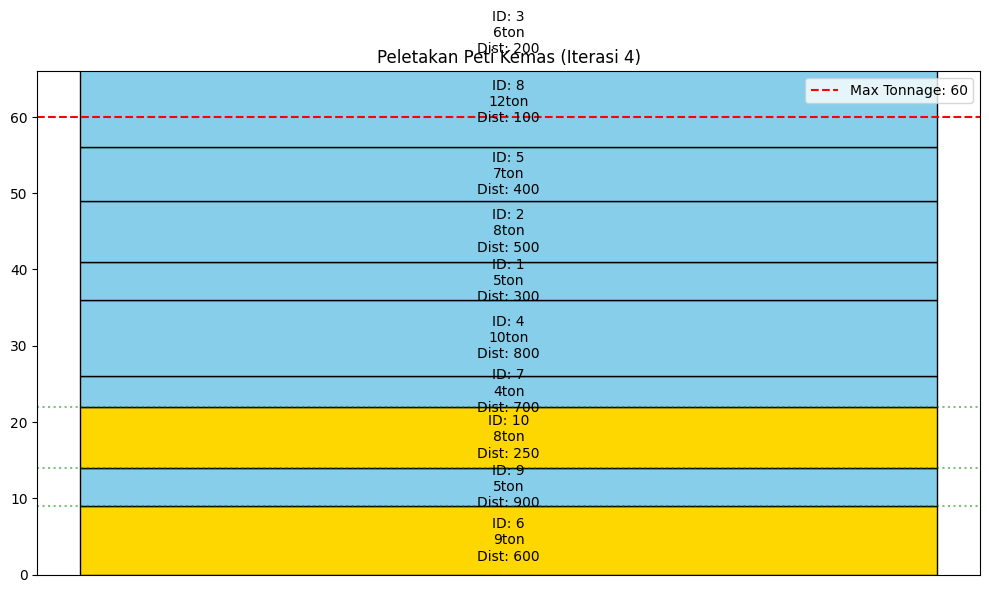

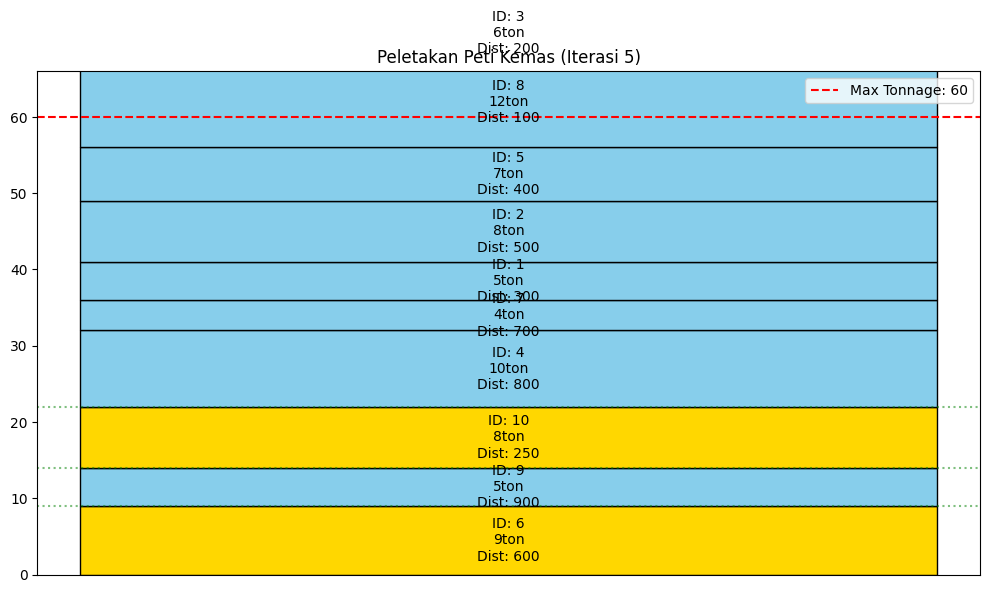

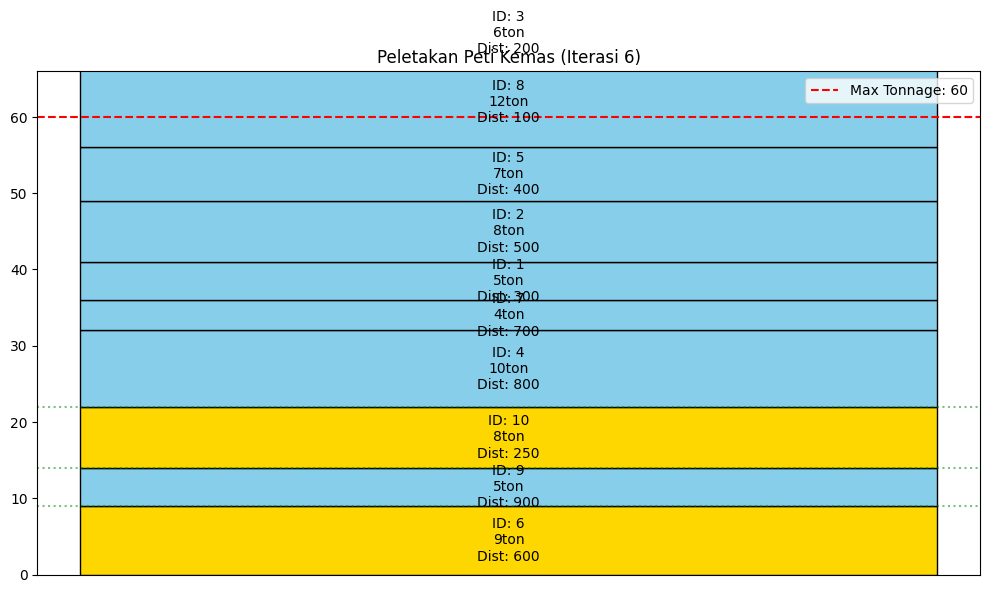

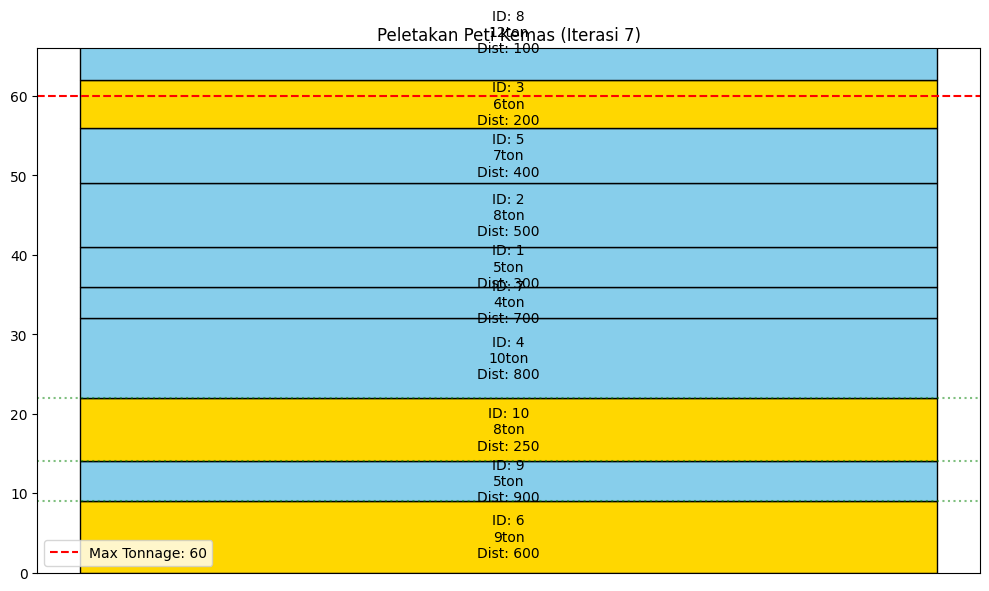

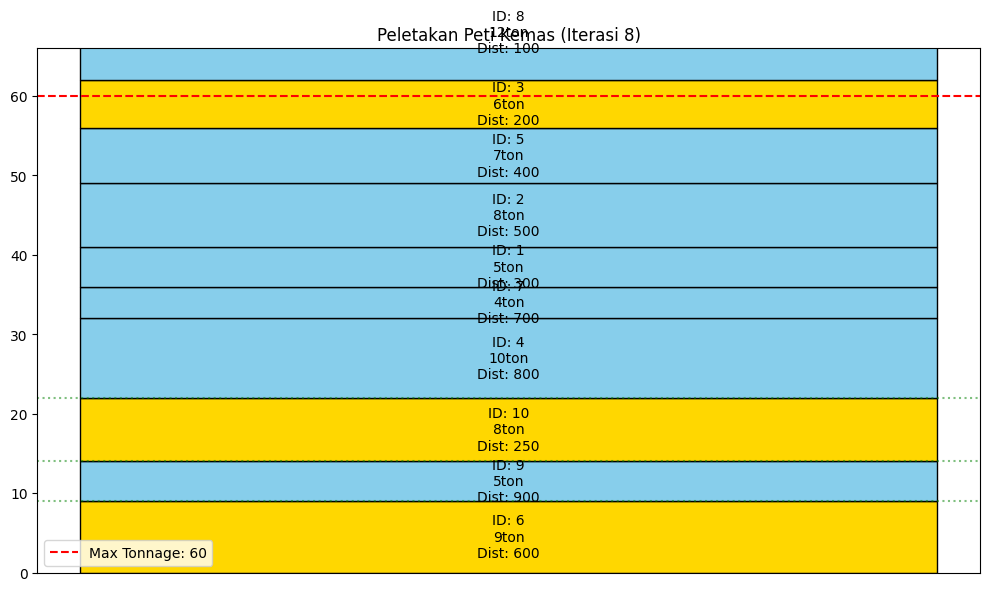

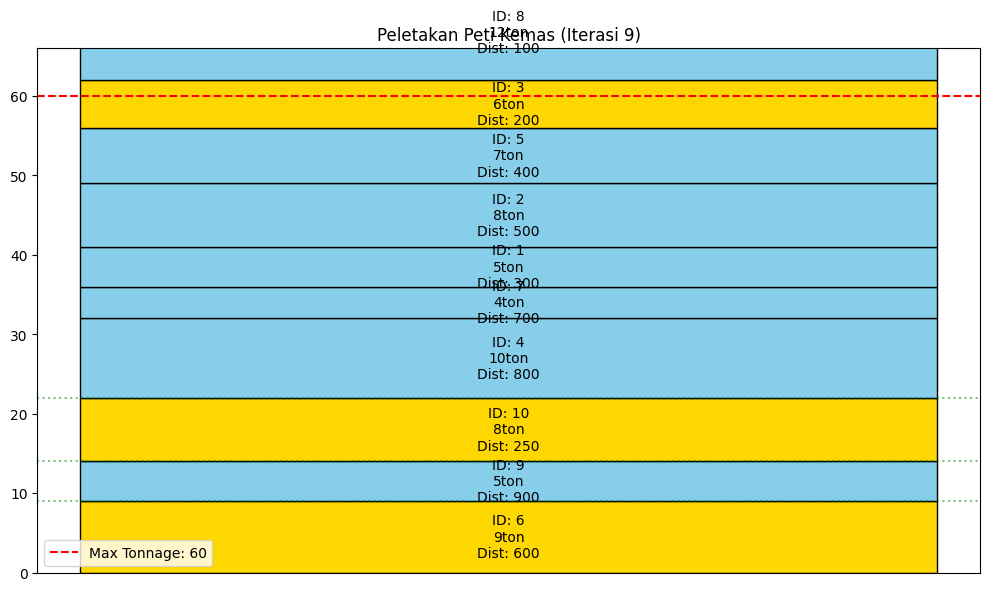

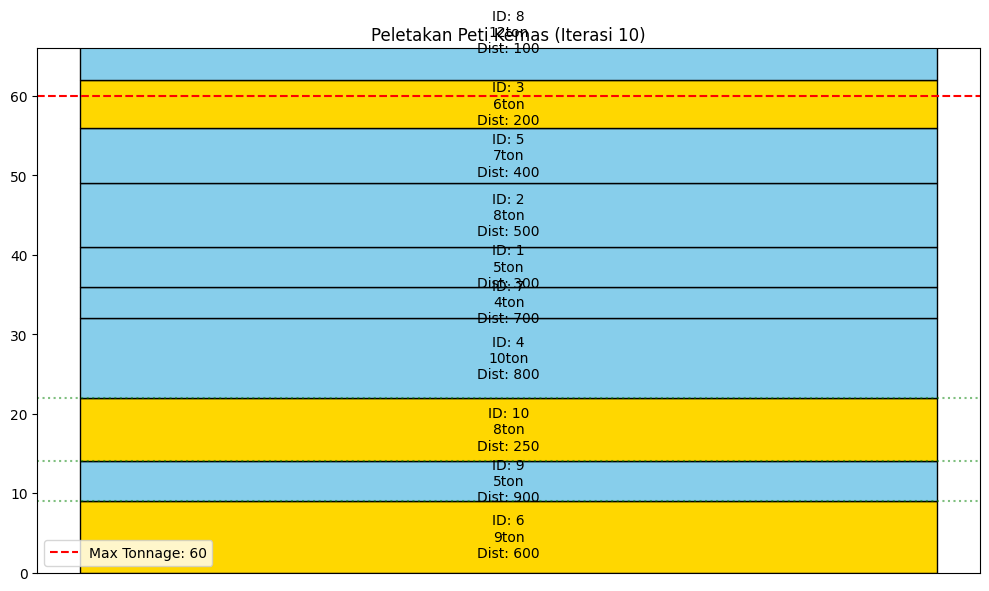

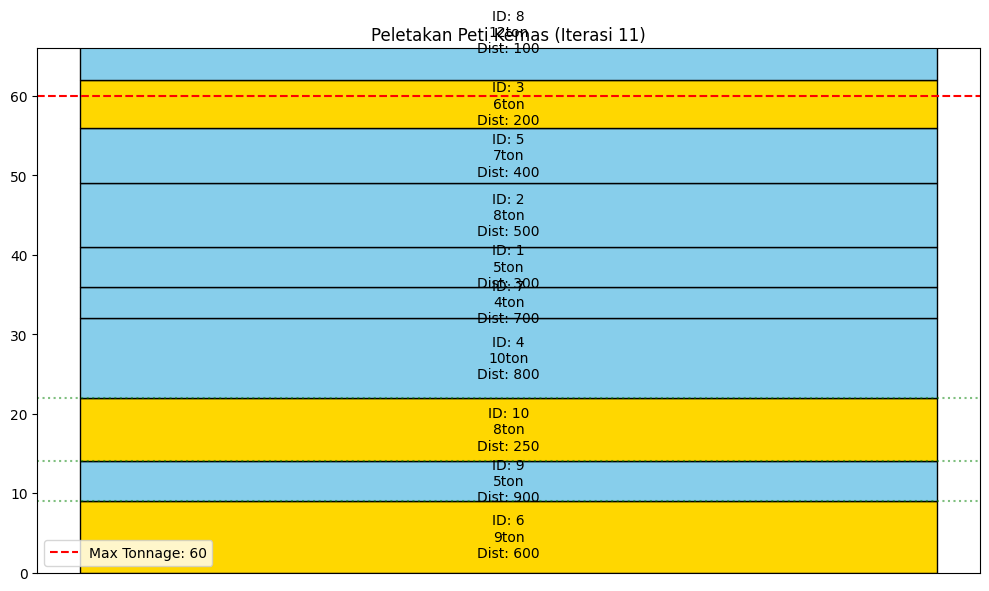

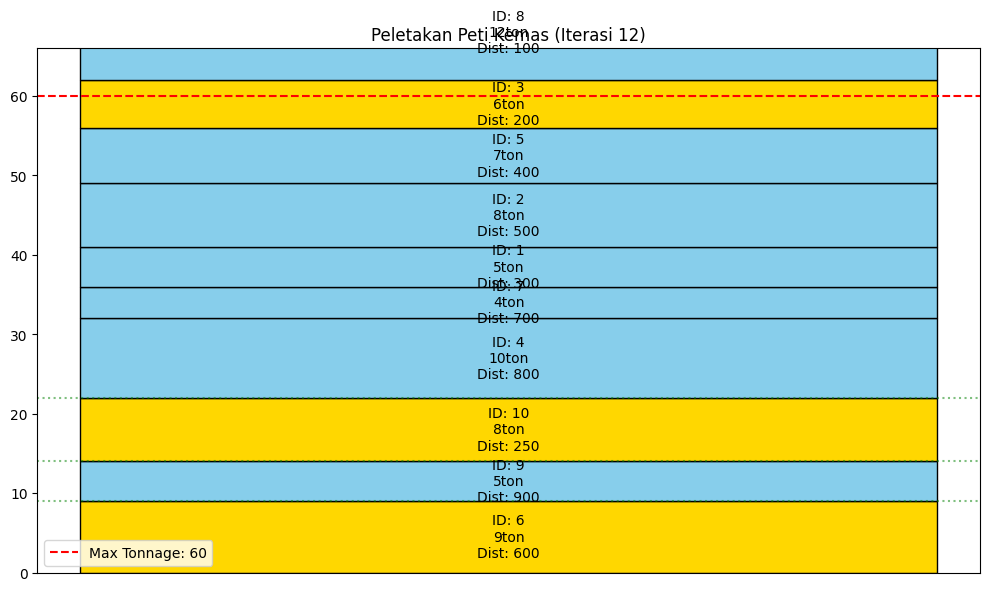

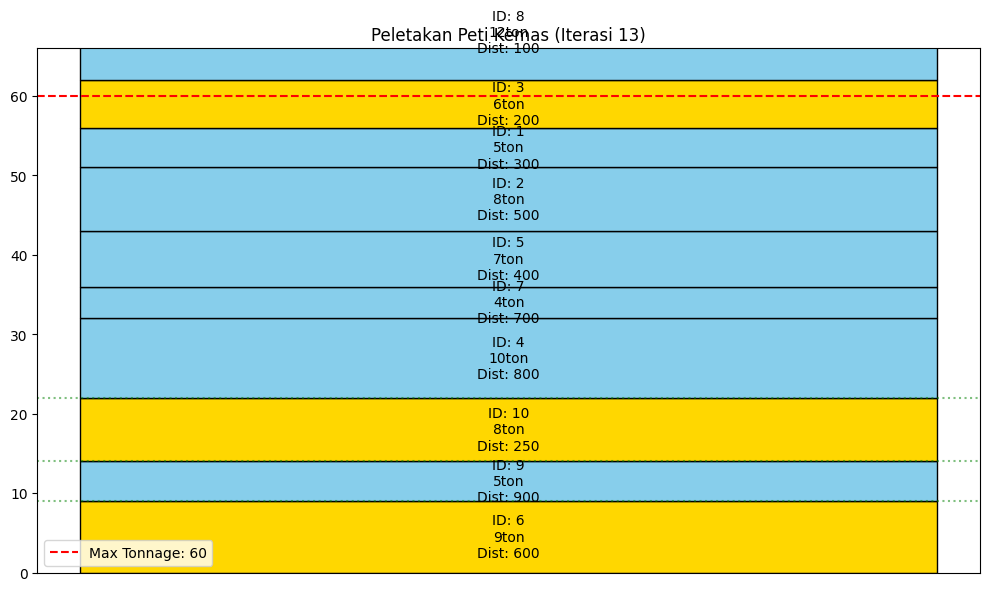

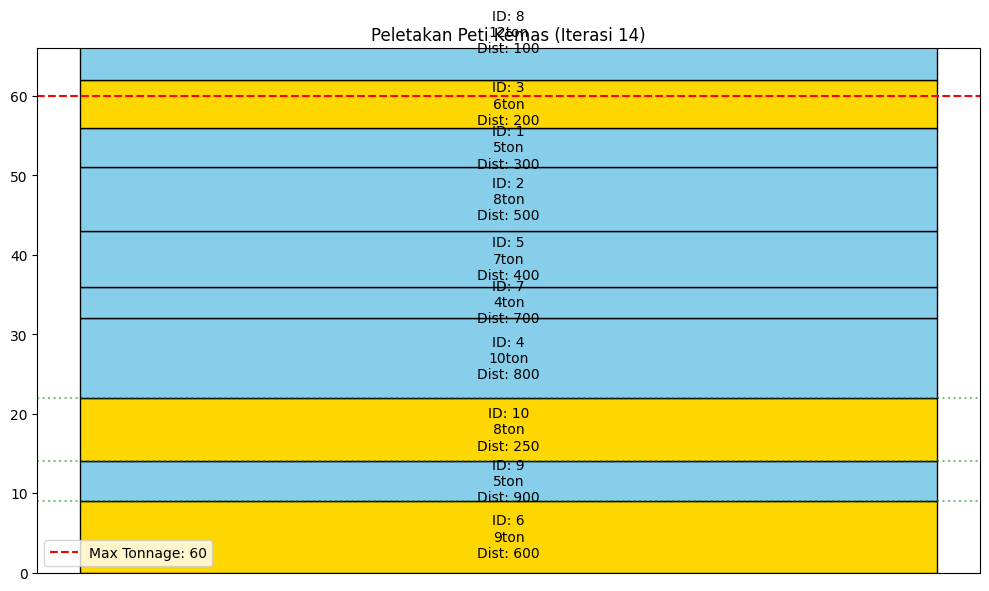

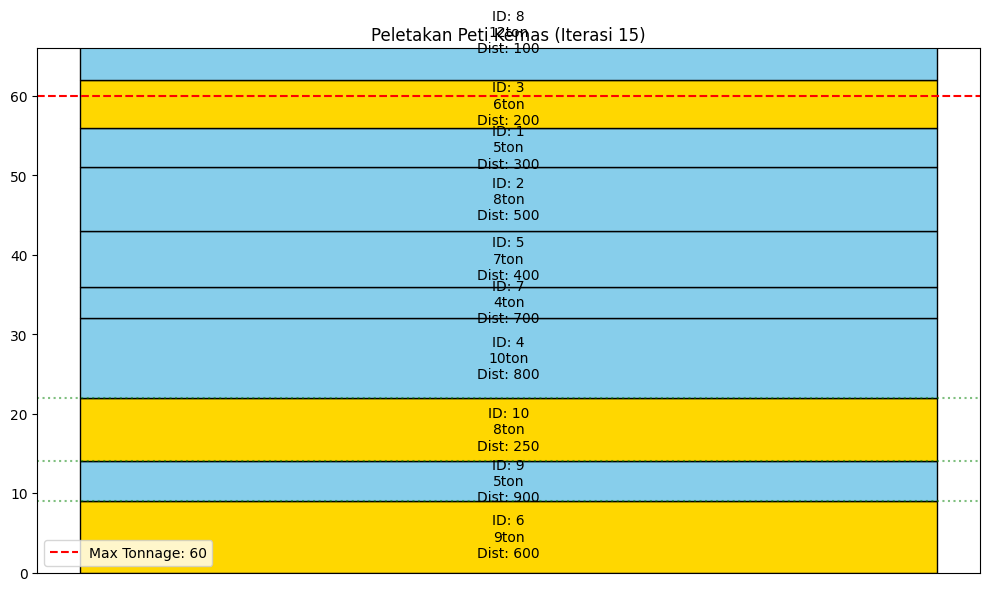

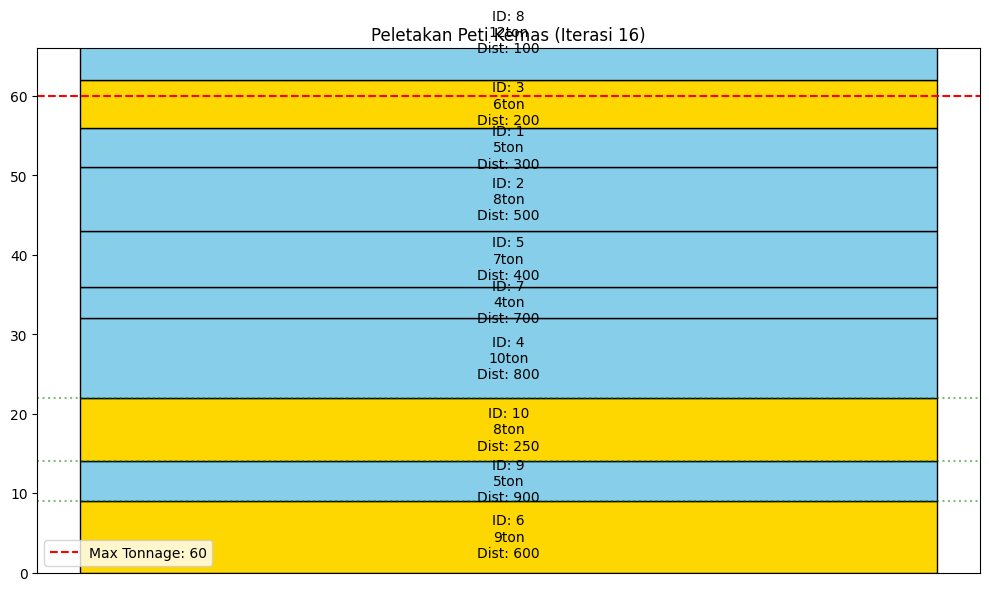

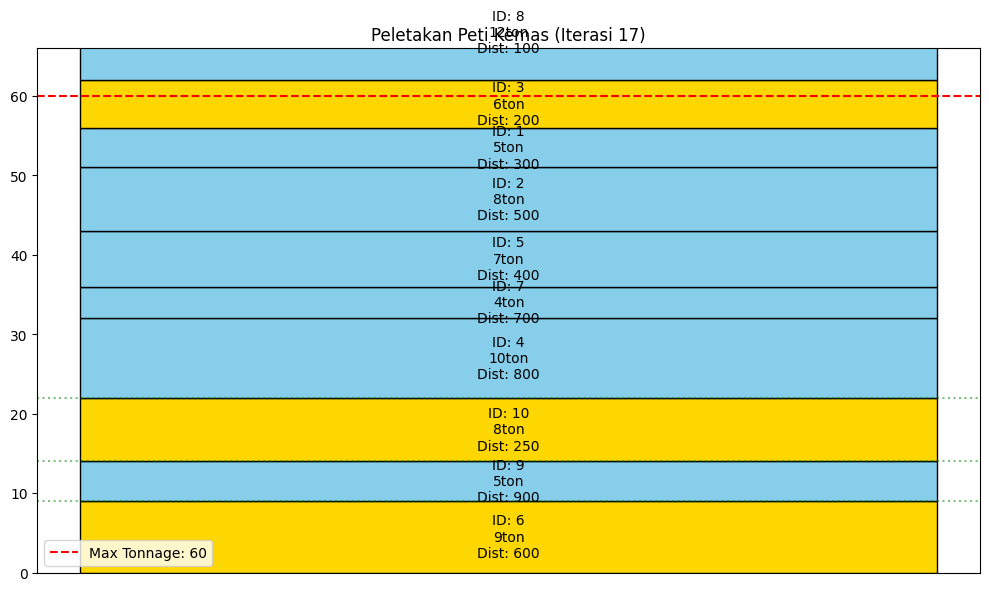

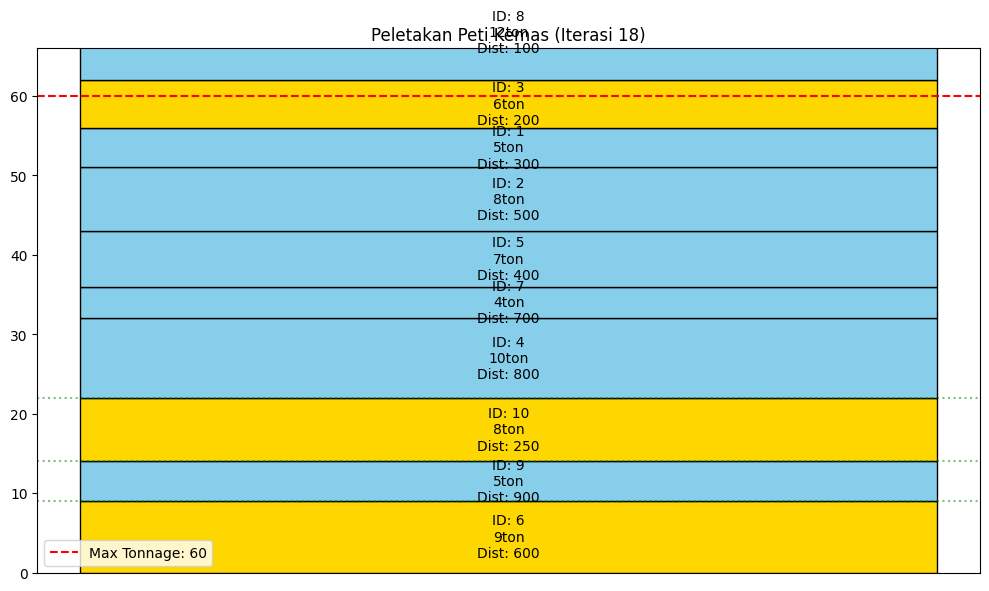

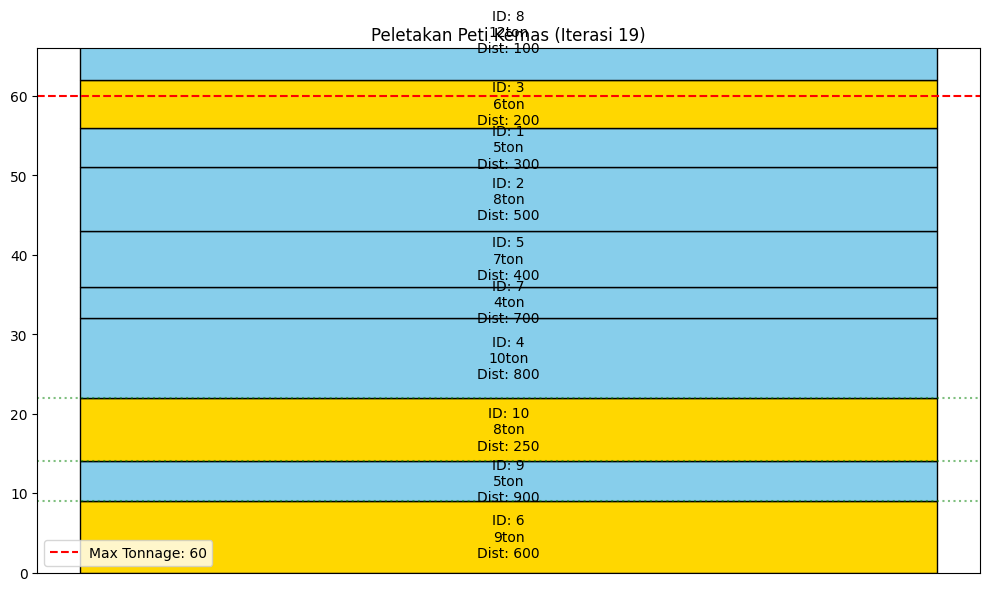

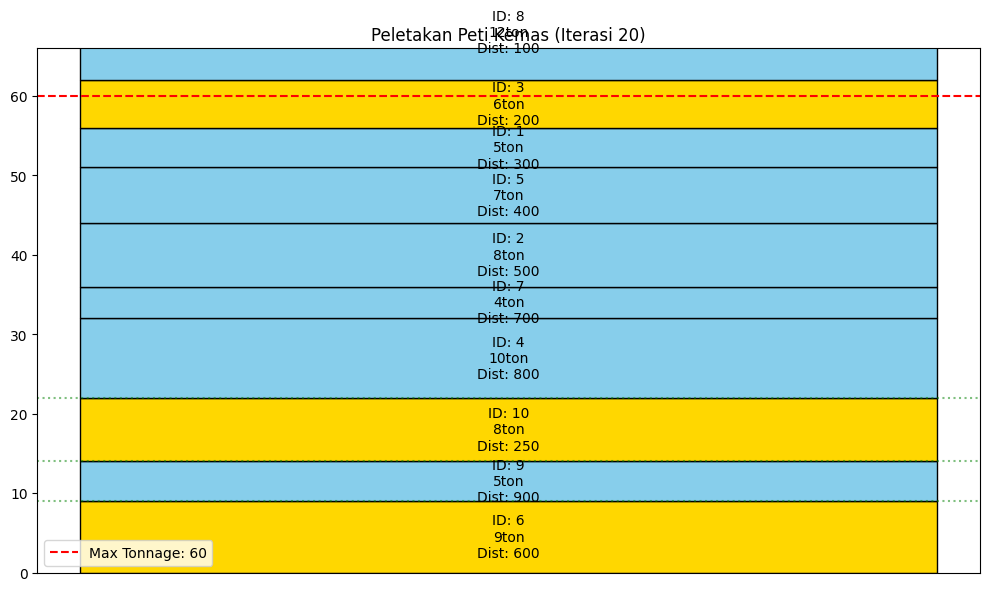

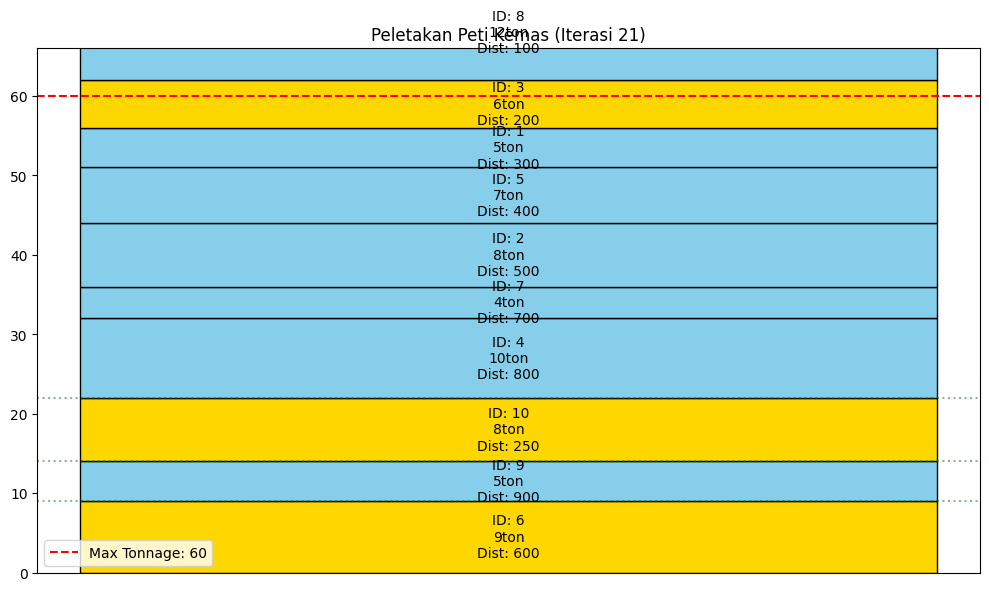

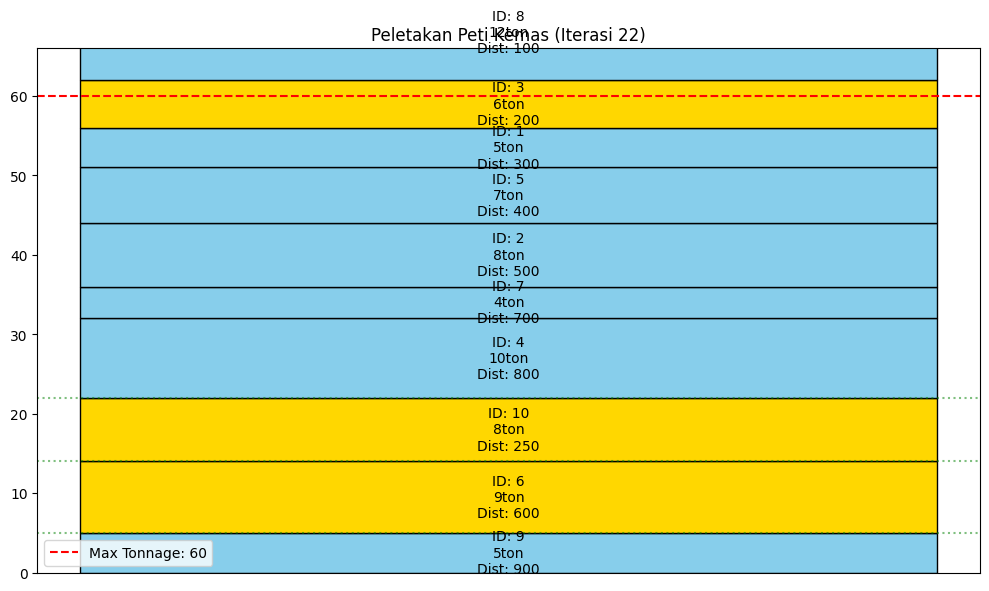

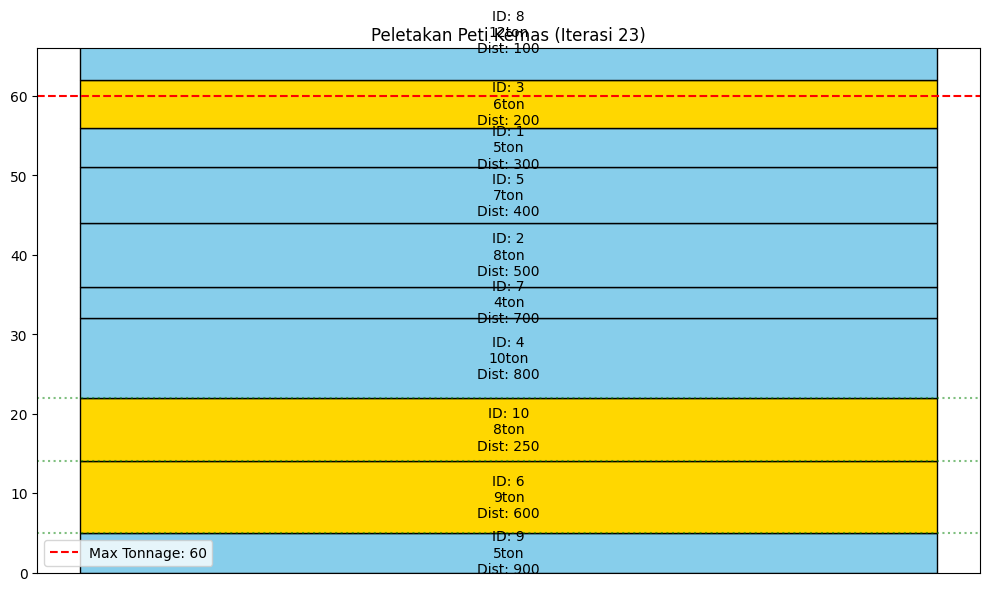

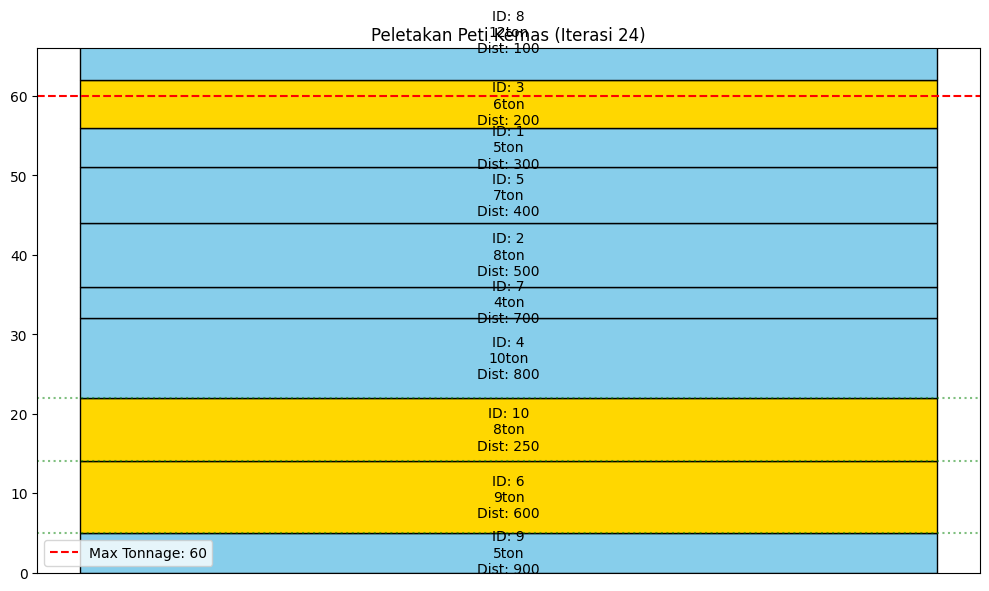

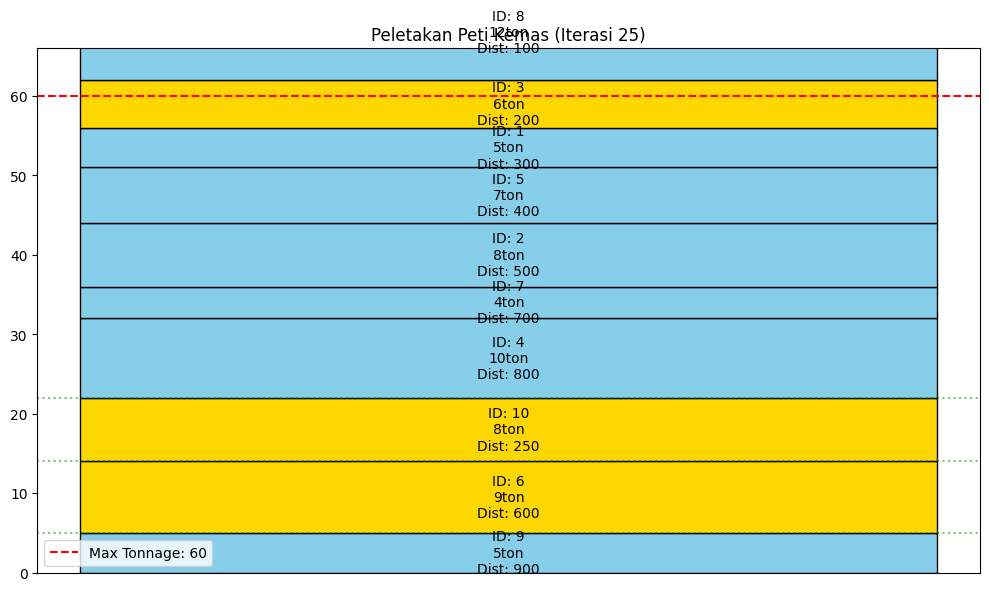

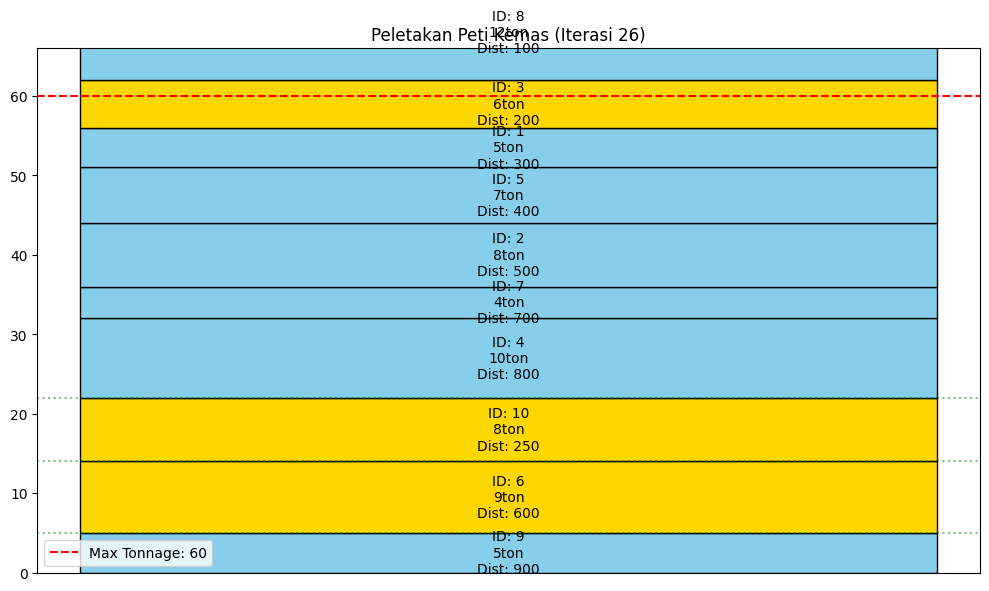

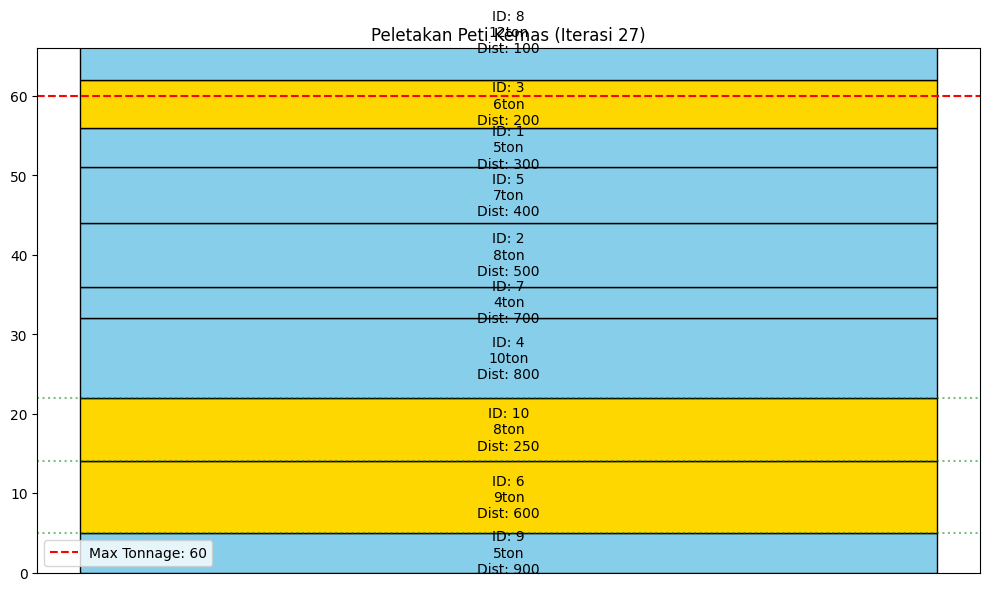

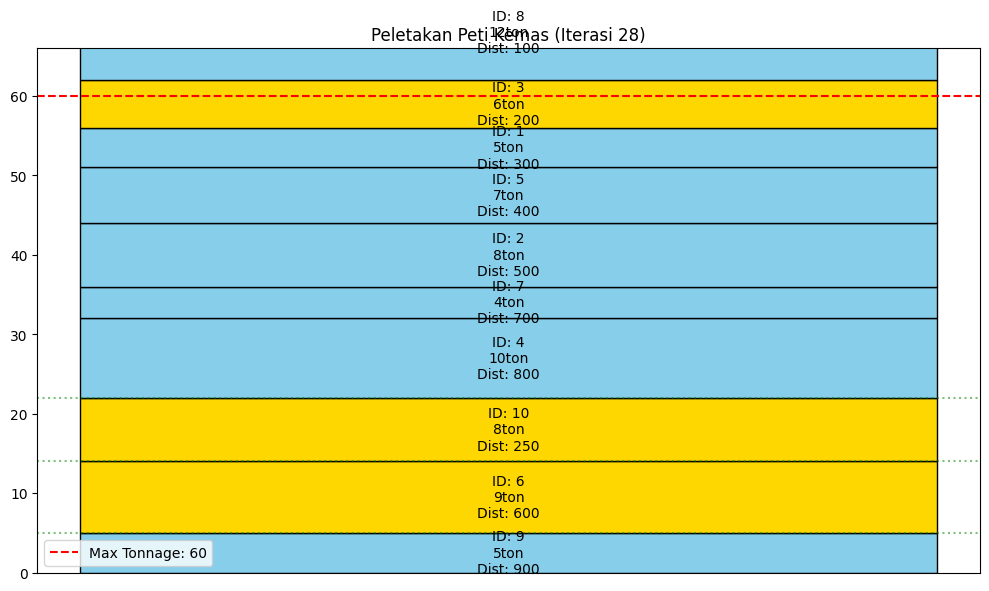

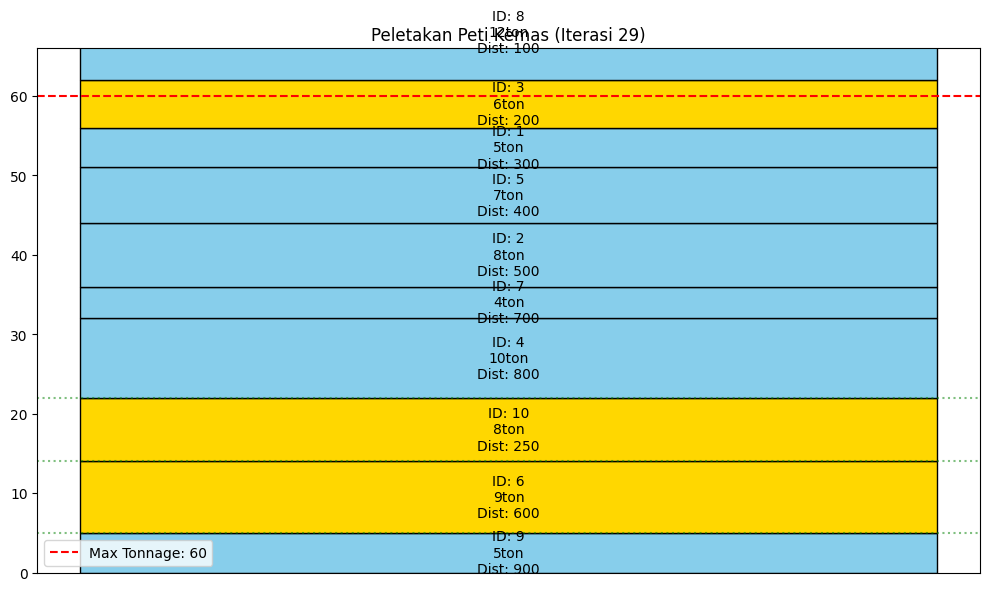

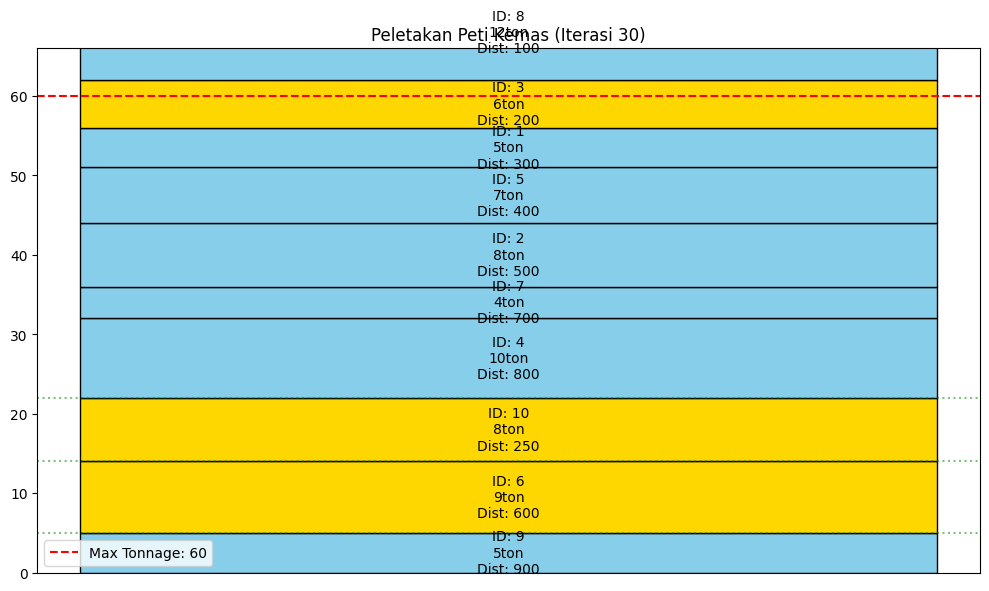

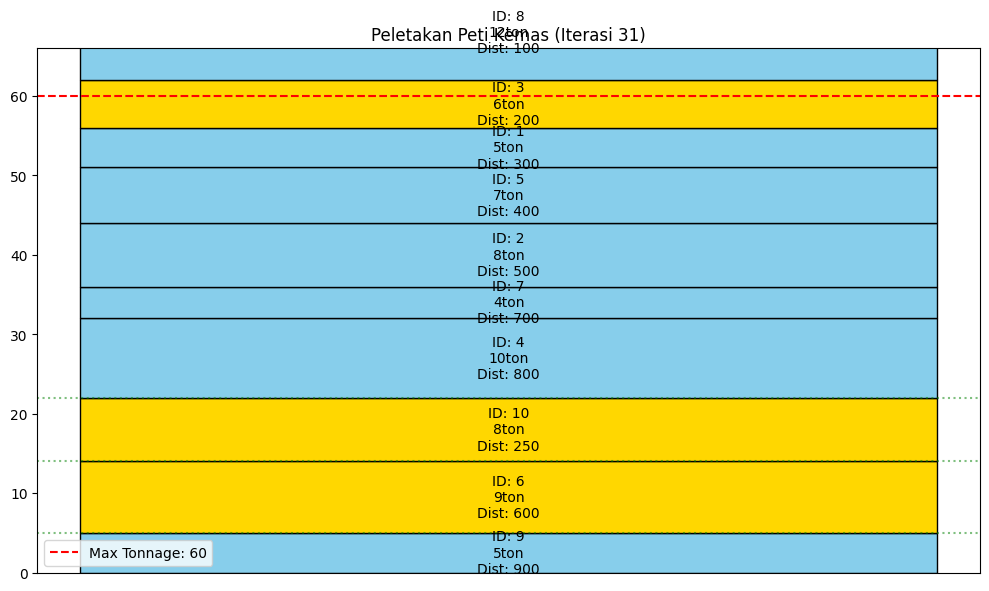

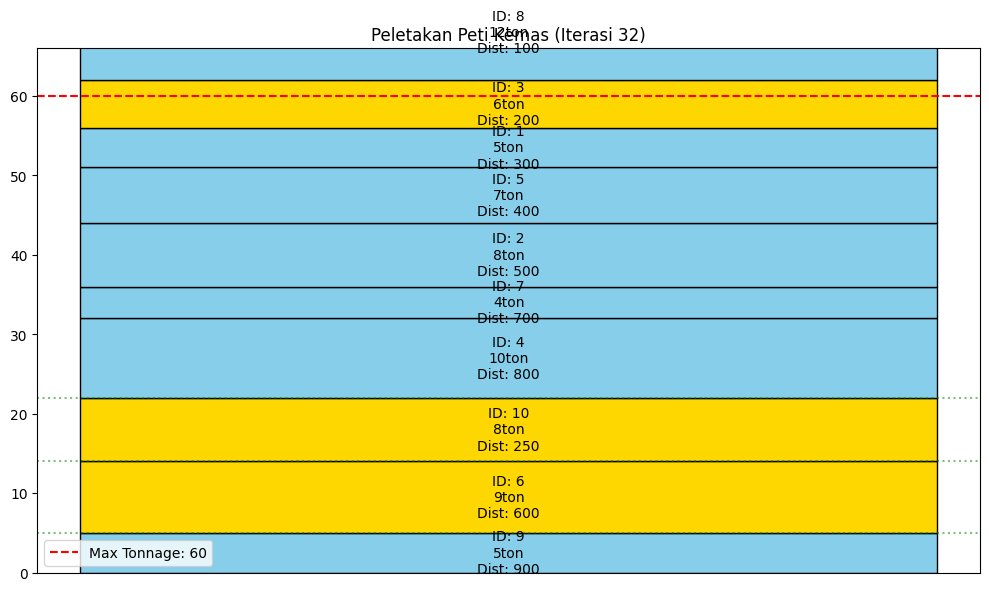

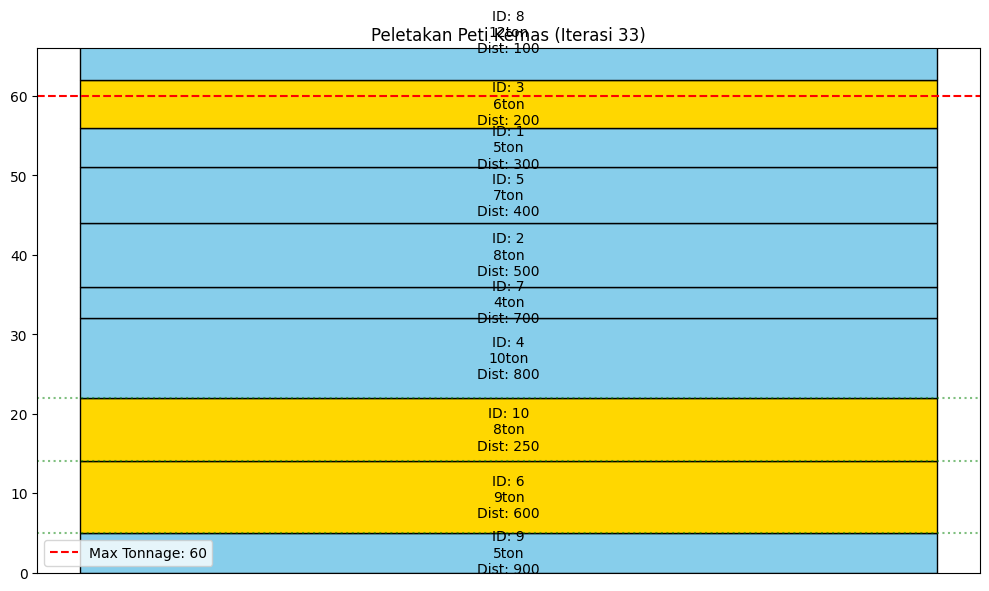

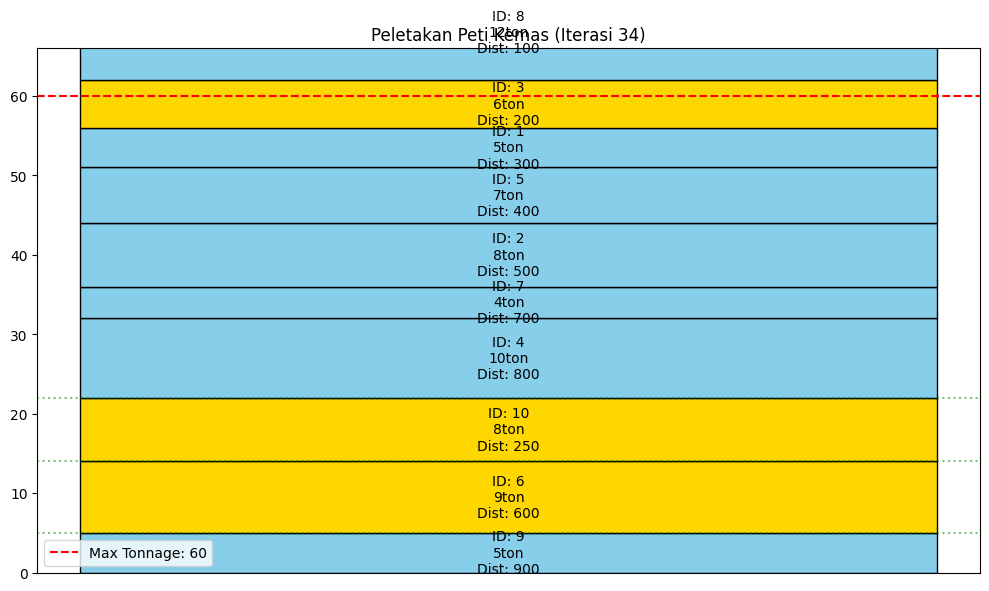

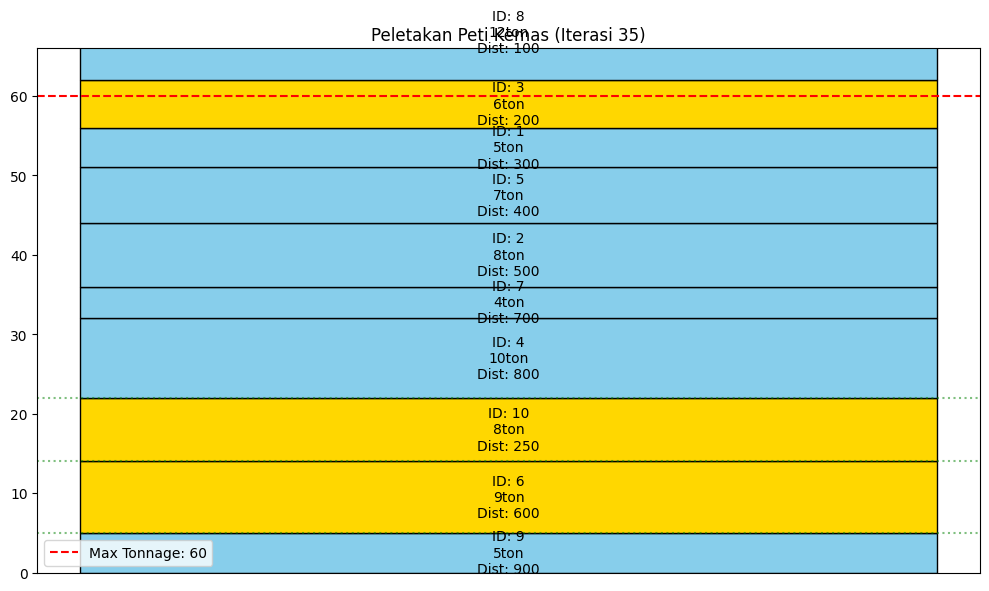

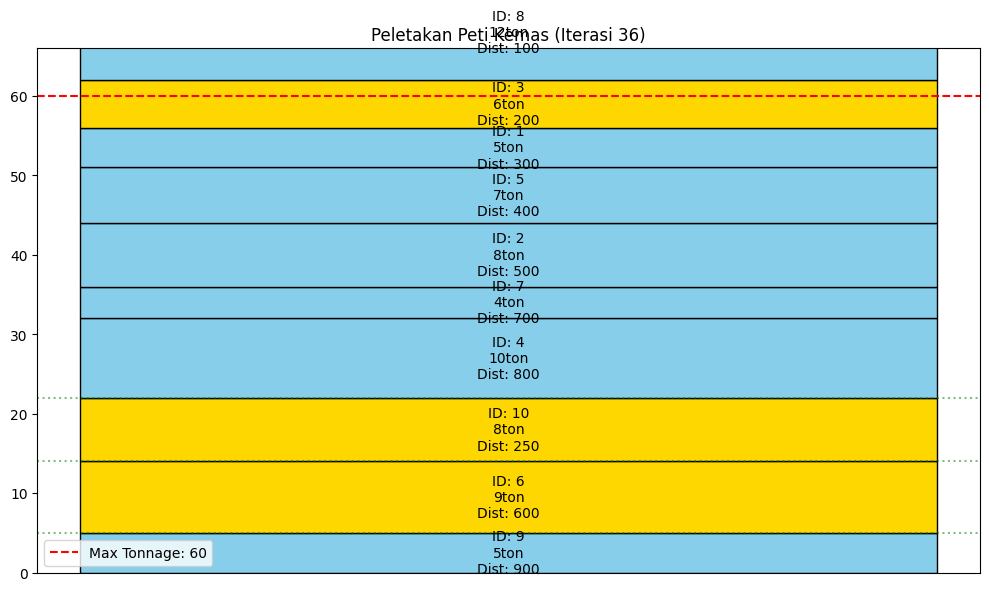

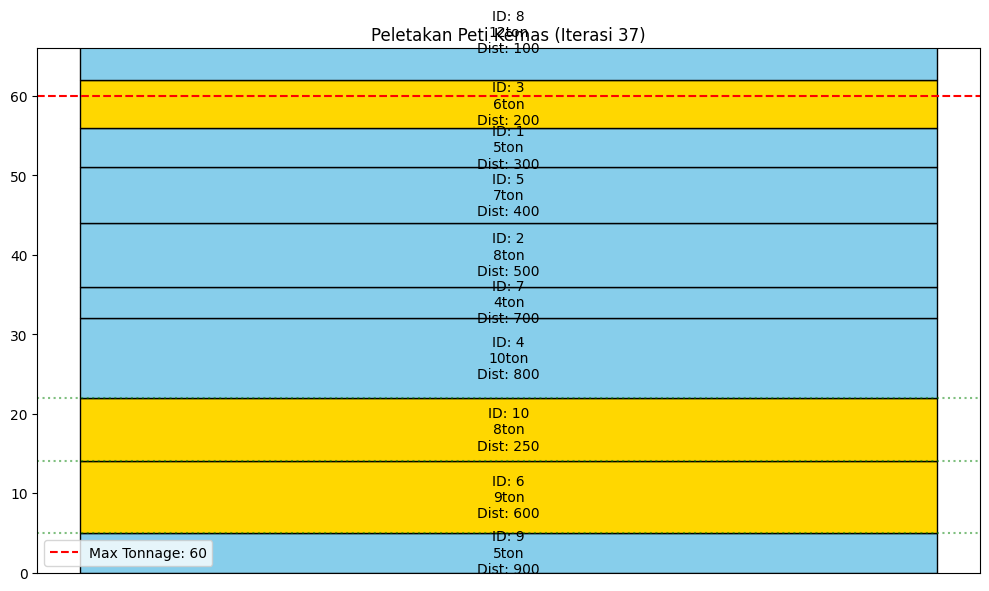

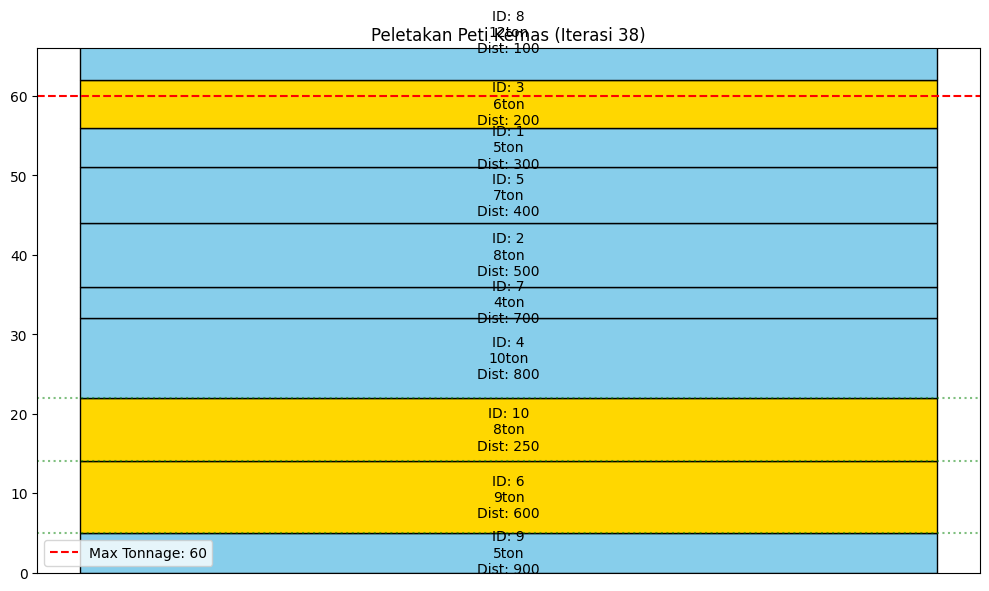

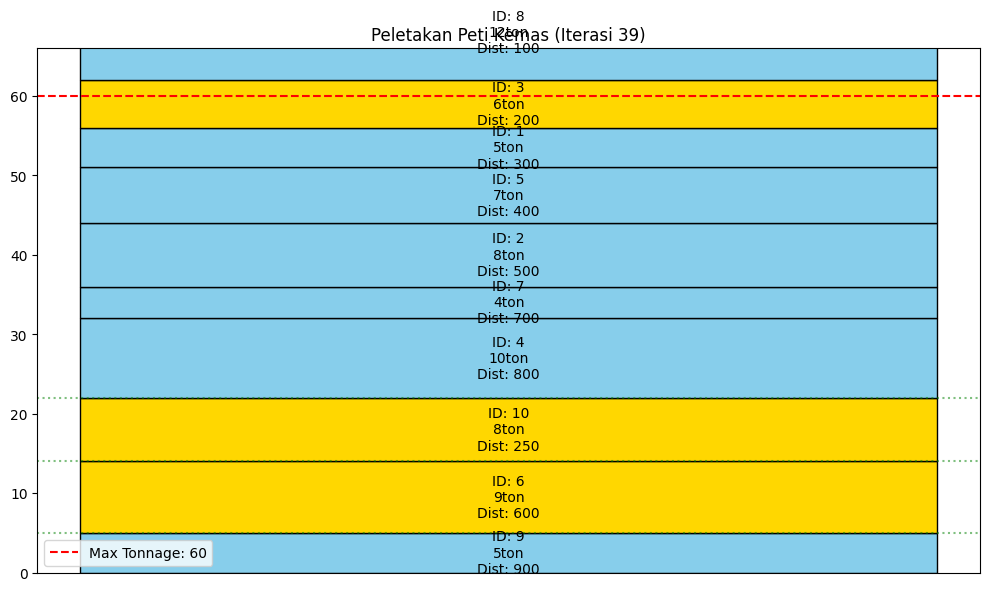

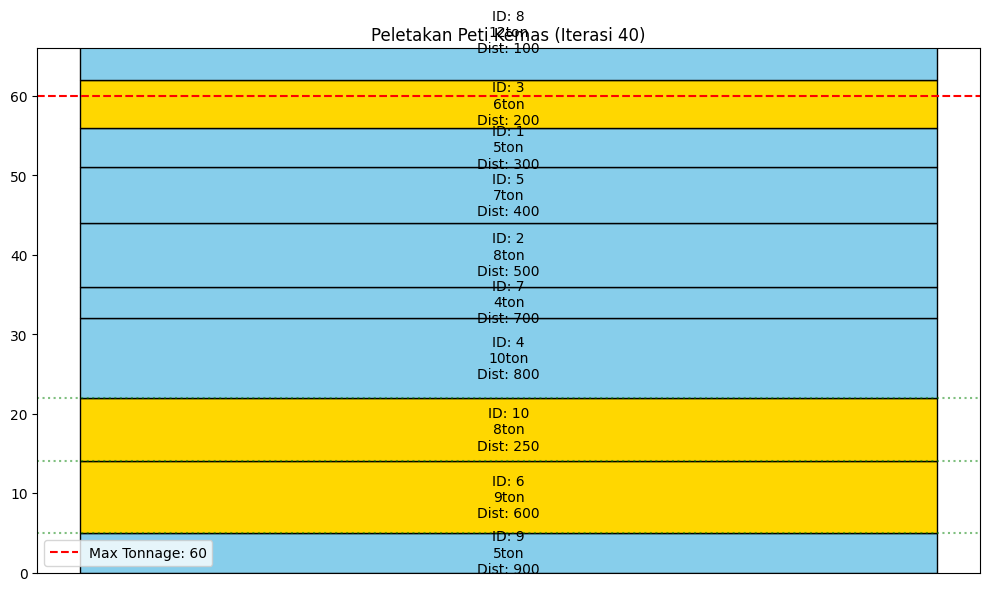

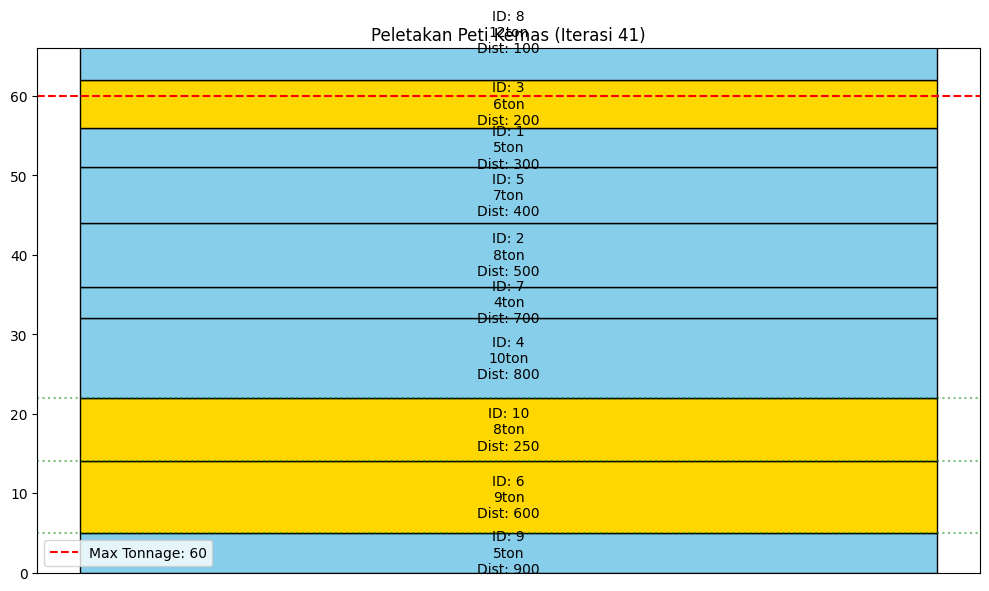

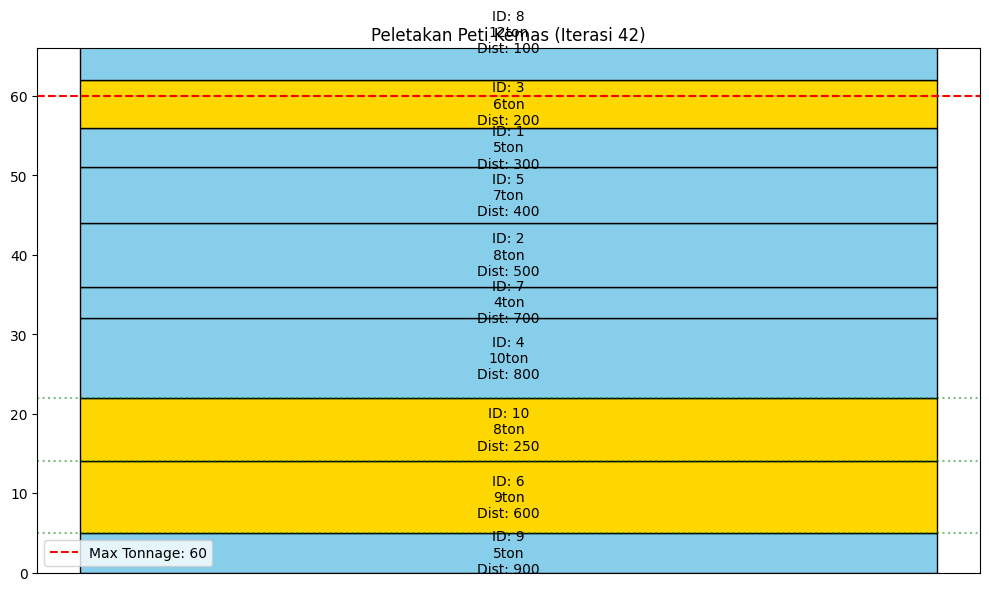

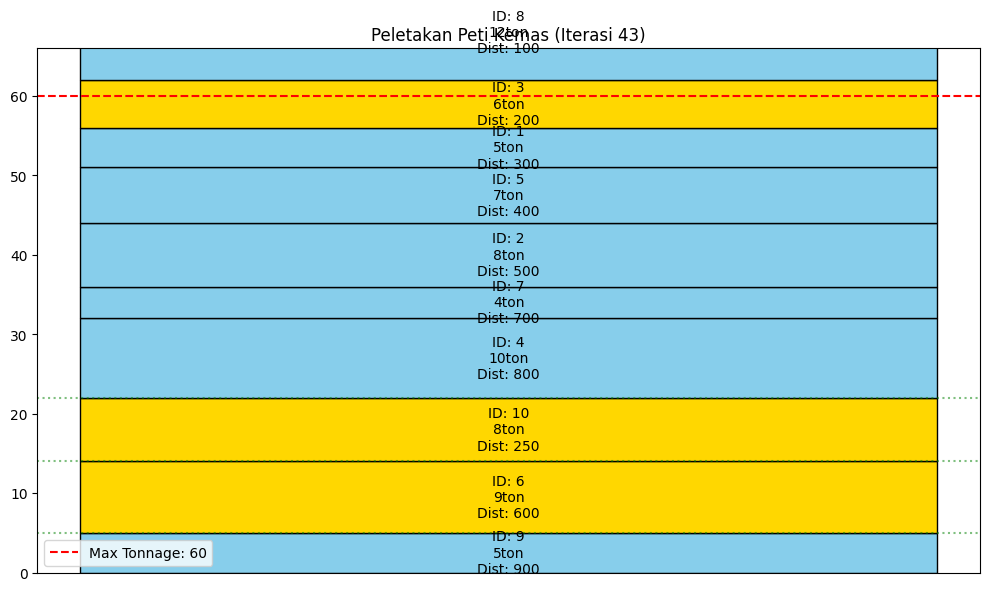

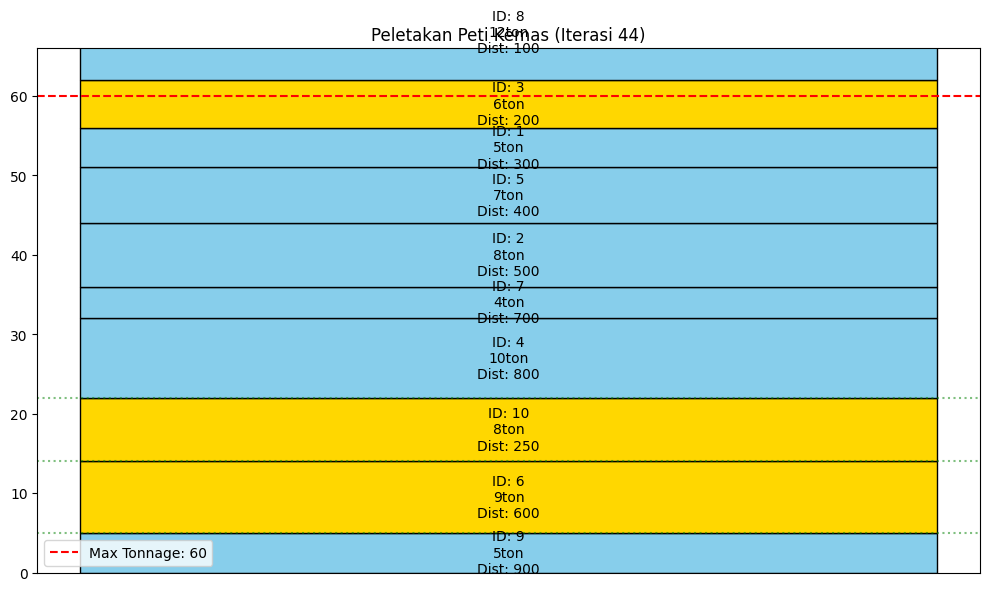

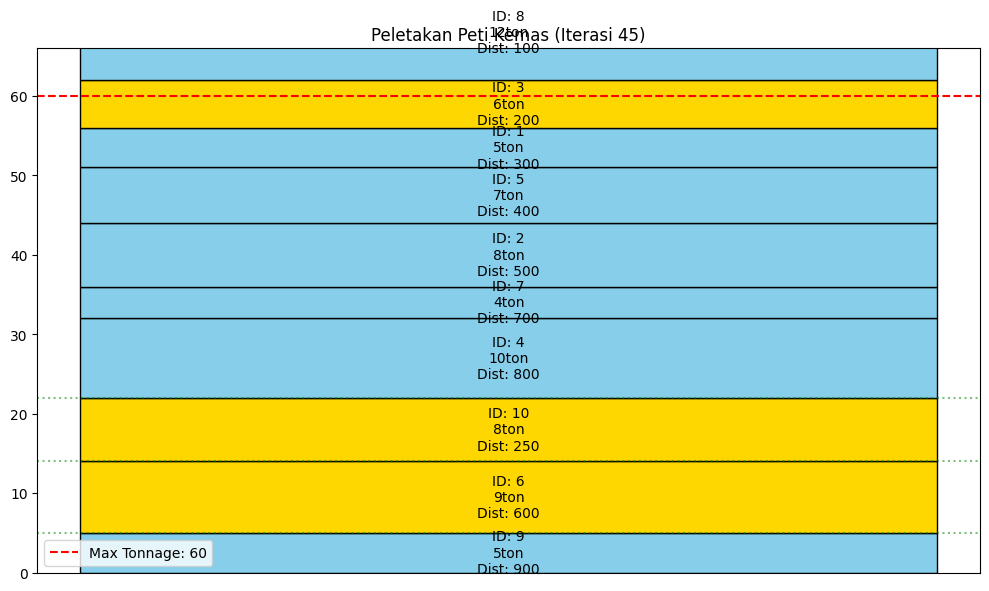

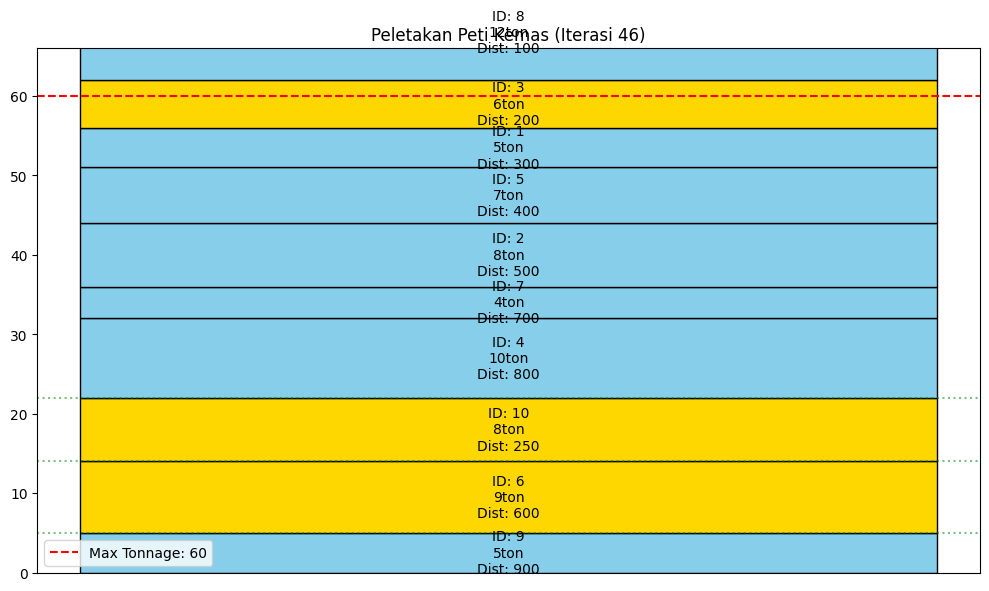

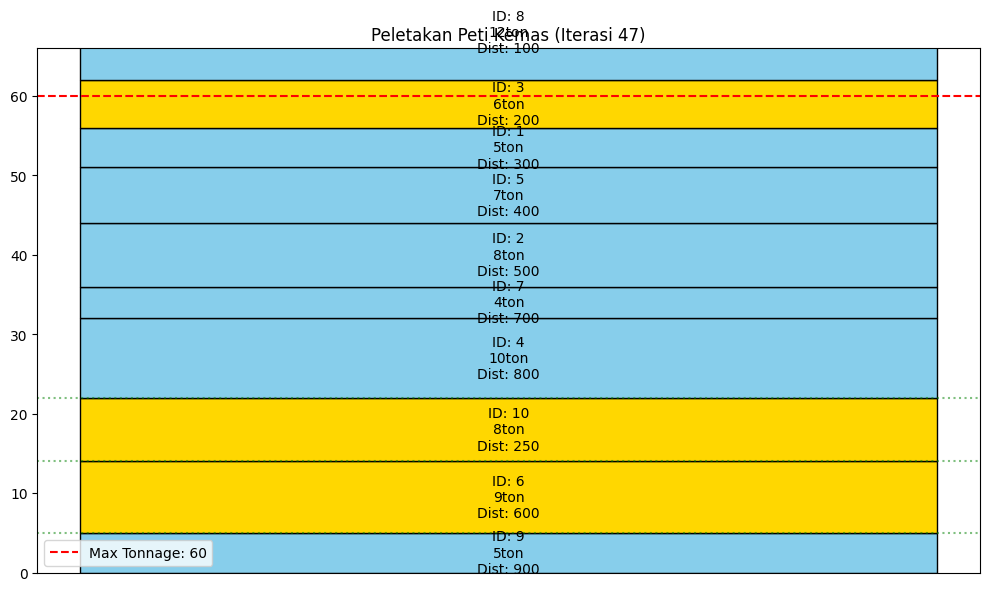

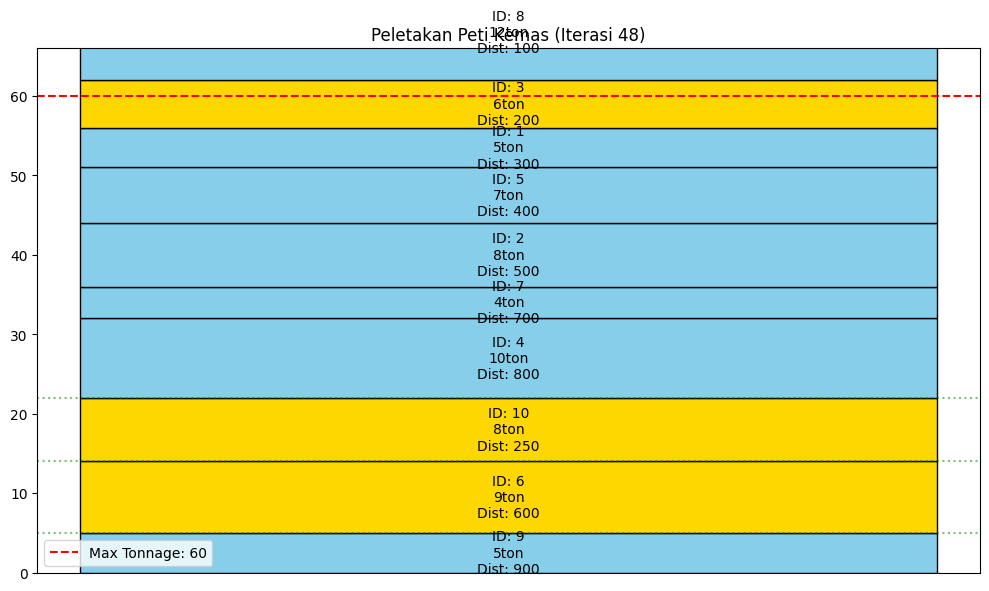

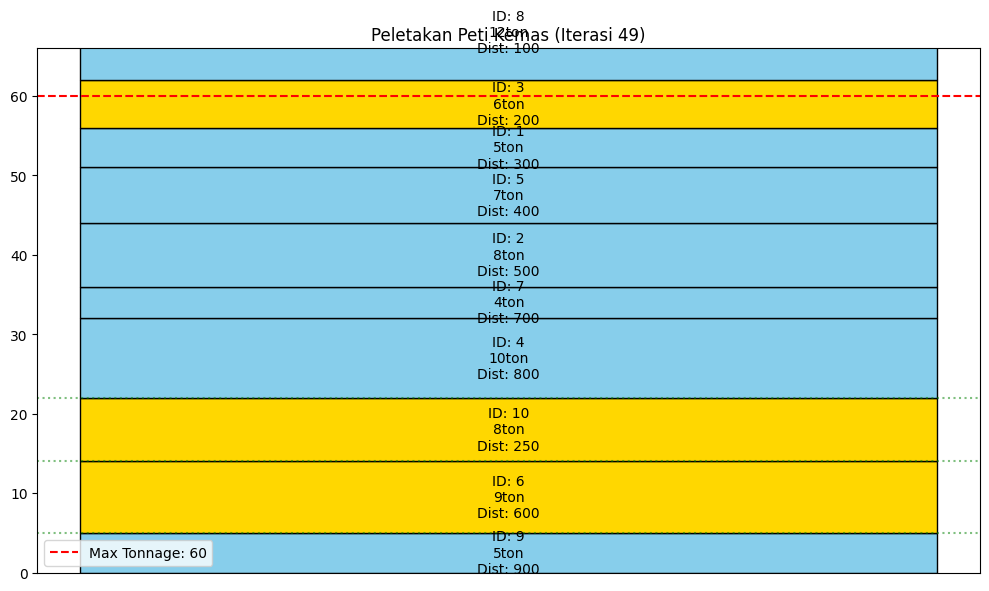

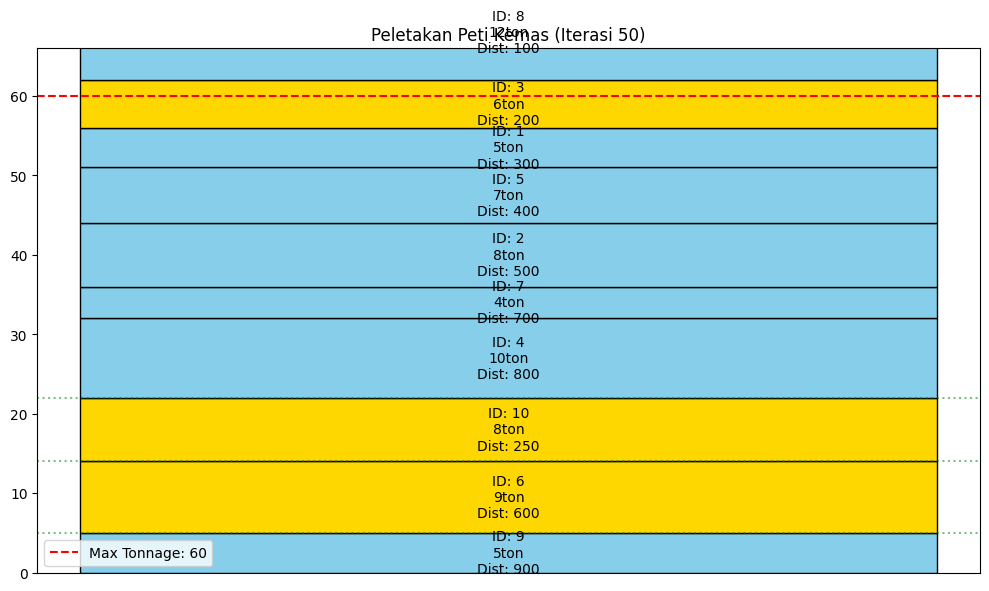


Detail Hasil per Iterasi:
Iterasi 1:
  Best Position: [7, 6, 10, 2, 4, 1, 3, 5, 8, 9]
  Best Fitness: -12000
  Avg Fitness: -18750.0
Iterasi 2:
  Best Position: [6, 4, 10, 7, 9, 1, 3, 5, 8, 2]
  Best Fitness: -11000
  Avg Fitness: -16416.666666666668
Iterasi 3:
  Best Position: [6, 9, 10, 7, 4, 1, 2, 5, 8, 3]
  Best Fitness: -9000
  Avg Fitness: -14633.333333333334
Iterasi 4:
  Best Position: [6, 9, 10, 7, 4, 1, 2, 5, 8, 3]
  Best Fitness: -9000
  Avg Fitness: -13716.666666666666
Iterasi 5:
  Best Position: [6, 9, 10, 4, 7, 1, 2, 5, 8, 3]
  Best Fitness: -8500
  Avg Fitness: -13283.333333333334
Iterasi 6:
  Best Position: [6, 9, 10, 4, 7, 1, 2, 5, 8, 3]
  Best Fitness: -8500
  Avg Fitness: -11766.666666666666
Iterasi 7:
  Best Position: [6, 9, 10, 4, 7, 1, 2, 5, 3, 8]
  Best Fitness: -8000
  Avg Fitness: -11150.0
Iterasi 8:
  Best Position: [6, 9, 10, 4, 7, 1, 2, 5, 3, 8]
  Best Fitness: -8000
  Avg Fitness: -10866.666666666666
Iterasi 9:
  Best Position: [6, 9, 10, 4, 7, 1, 2, 5, 3, 

In [46]:
container_map = {c[0]: c for c in containers}
total_tonnage = sum(container_map[c_id][1] for c_id in gbest_position)
special_containers = sum(1 for c_id in gbest_position if container_map[c_id][2] == 1)

print("\nTotal Tonase:", total_tonnage, "ton dari maksimum", ship_max_tonnage, "ton")
print("Jumlah peti kemas khusus:", special_containers)

print("\nPeletakan Peti Kemas (dari bawah ke atas):")
print("Position | ID | Tonase | Jenis | Tujuan (km) | Keterangan")
print("-" * 70)

for i, container_id in enumerate(gbest_position):
    container = container_map[container_id]
    container_type = "Khusus" if container[2] == 1 else "Biasa"
    special_location = "Lokasi Khusus" if i in special_container_locations else ""
    print(f"{i:8d} | {container_id:2d} | {container[1]:6d} | {container_type:6s} | {container[3]:11d} | {special_location}")

for iteration in range(max_iterations):
    fig = visualize_container_placement(iteration_data[iteration]['gbest_position'], iteration + 1)
    plt.tight_layout()
    plt.show()

print("\nDetail Hasil per Iterasi:")
for data in iteration_data:
    print(f"Iterasi {data['iteration']}:")
    print(f"  Best Position: {data['gbest_position']}")
    print(f"  Best Fitness: {data['gbest_fitness']}")
    print(f"  Avg Fitness: {sum(p['fitness'] for p in data['particles']) / len(data['particles'])}")